## I. Import + Load Data

In [1]:
# ------- IMPORTS
# -- model(s)
from cobras_ts.querier.labelquerier import LabelQuerier
from xcobras_kmeans import XCOBRAS_kmeans
from model_explainer import PartTwo
import shap

# -- plot(s)
from utils.plots import plot_2D, plot_boundary
import matplotlib.pyplot as plt

# -- dataset(s) 
from sklearn import datasets
from scipy.io import arff
import pandas as pd
import numpy as np

# -- others
import warnings
warnings.filterwarnings("ignore")


# ------- CREATE TOY DATASET
n_samples = 500
X_blob0, y_blob0 = datasets.make_blobs(n_samples=n_samples, centers=3, n_features=2, random_state=0)
X_blob1, y_blob1 = datasets.make_blobs(n_samples=n_samples, centers=3, n_features=2, random_state=1)
X_moons1, y_moons1 = datasets.make_moons(n_samples=n_samples, noise=0.1, random_state=1)
# on verra comment les print

# ------- READ REAL DATASET
PATH = "../../../datasets/deric benchmark/"
ARTIFICIAL = PATH+"artificial/"
REALWORLD = PATH+"real-world/"

datasets_path = [
    ARTIFICIAL+"target",
    REALWORLD+"wine",
    REALWORLD+"iris"
]

data = {}
for dataset_path in datasets_path:
    temp_data = arff.loadarff(open(dataset_path+".arff", 'r'))
    dataset_name = dataset_path.split("/")[-1]
    data[dataset_name] = pd.DataFrame(temp_data[0])
    data[dataset_name]["class"] = data[dataset_name]["class"].str.decode('utf-8') 

In [2]:
X = data["wine"].drop(["class"], axis=1)
y = data["wine"]["class"]
feature_names = list(X.columns)

budget = 160

In [3]:
xcobras_kmeans = XCOBRAS_kmeans(budget)
xcobras_kmeans.fit(X.values, LabelQuerier(y.values))
y_hat = xcobras_kmeans.predict(X.values)

In [4]:
part_two = PartTwo(verbose=True)
part_two.fit(X.values, y_hat)

---------Some scores:---------
------------------------------
f1-score (macro): 0.8501049233252623
         (micro): 0.8611111111111112
accuracy_score:   0.8611111111111112
------------------------------


### Shap

**General idea:**  
1. Get all the instances of a certain cluster
2. Explain the whole cluster
3. Show explanation of 2 samples

In [5]:
import shap

# 1  .................
label = np.random.choice(list(set(y_hat)))
print(f"Chosen label: {label}")
X_label = X[list(y_hat)==label]
print(f"Number of instances: {X_label.shape[0]}")

Chosen label: 0
Number of instances: 56


In [6]:
# 2  .................
#  ---- COBRAS
explainer_XCOBRAS_kmeans = shap.Explainer(
    xcobras_kmeans.predict,
    X_label.values,
    feature_names=list(X.columns)
)
print("XCOBRAS explainer .... ")
XCOBRAS_shap_values = explainer_XCOBRAS_kmeans(X_label.values)


#  ---- PartTwo (RBF SVM)
explainer_part_two = shap.Explainer(
    part_two.predict,
    X_label.values,
    feature_names=list(X.columns)
)
print("PartTwo explainer .... ")
part_two_shap_values = explainer_part_two(X_label)

XCOBRAS explainer .... 


Permutation explainer: 57it [03:37,  3.95s/it]                        


PartTwo explainer .... 


Permutation explainer: 57it [00:33,  1.16it/s]                        


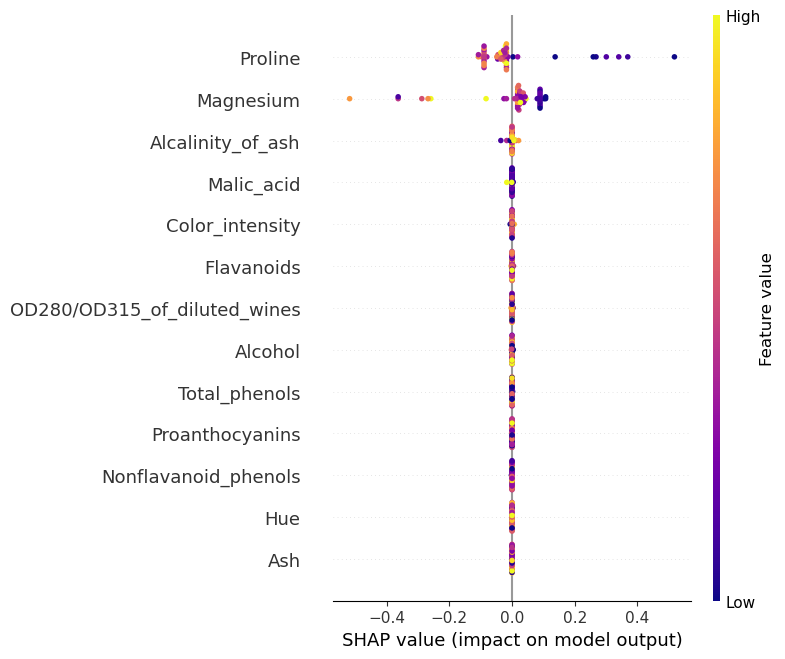

In [7]:
# 3  .................
shap.summary_plot(XCOBRAS_shap_values,
                  X_label.values,
                  cmap = "plasma")

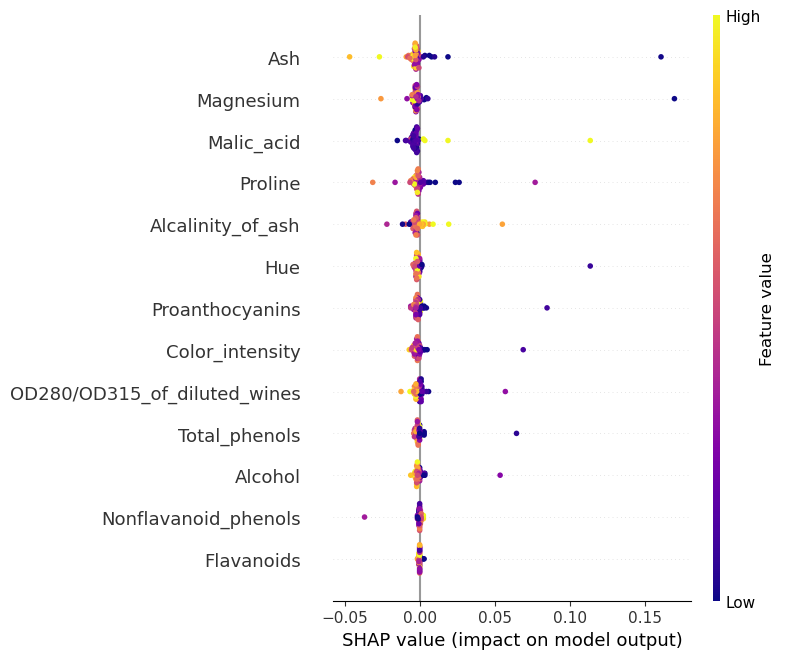

In [8]:
shap.summary_plot(part_two_shap_values,
                  X_label.values,
                  cmap = "plasma")